<H1>The Problem</H1>

<H4>Where to open a new Italian Restaurant in New York?

This is a complex problem which requires the consideration of numerous factors like nearby restaurants, rent, popularity of the cuisine, profitability of other restaurants in that location, etc. We will look at two main components.

1> Nearby Restaurants
Ideally we should try to minimise competition. At the same time, we cannot open a restaurant in a remote location and expect it to be profitable. So, we will try to identify neighbourhoods which have a small number of restaurants.

2> Popularity of the cuisine
It is important to target areas where Italian cuisine is popular. We will try to achieve this by checking the ratings of other Italian restaurants in the neighbourhood.</H4>

<H1>Target Audience</H1>

<H4>Anyone planning to open an Italian restaurant in New York</H4>

<H1> The Data</H1>

<H4>We will use the Foursquare API.

The API provides us with all the venues in the area. We will filter this data to identify all the Italian restaurants in each neighbourhood.

The API also provides us with ratings for each venue. We will use these ratings to ascertain the popularity of Italian restaurants in the area. If a venue has no ratings, we will assume the rating to be 0.

For example, Foursquare can tell us that there are two McDonald's in the Dw

We will group all the Italian restaurants in the neighbourhood by counting the number of restaurants and the mean of their ratings.
We will then use K-means clustering to group the neighbourhoods depending on the number of Italian restaurants and their average ratings.

Thus, we will obtain the neighbourhoods with lower number of Italian restaurants with high ratings.</H4>

<H2>Import Required Libraries</H2>

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.18.1-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00  23.62 MB/s
geopy-1.18.1-p 100% |################################| Time: 0:00:00  33.12 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  44.58 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  30.13 MB/s
vincent-0.4.4- 100% |###################

<H2>Import the data of New York neighborhoods along with their location co-ordinates</H2>

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),neighborhoods.shape[0]))


The dataframe has 5 boroughs and 306 neighborhoods.


<H2>Map the neighborhoods</H2>

In [3]:
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

<H2>Define a function to get category types</H2>

In [4]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


<H2>Define a function to get venues in the neighborhood</H2>

In [5]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        try:
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name'],
                v['venue']['id']) for v in results])
        except:
            continue
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue Id']
    
    return(nearby_venues)


<H2>Using Foursquare, generate a dataframe with all the desired fields</H2>

In [6]:
CLIENT_ID = 'SGIPQUYVFFHIENETLAKBAVFEUWGR4UDQQCQDJJC2E2255UD4'
CLIENT_SECRET = 'FF3W4SWNO3BLJGQ4EFHO5Y1O0ZM5T1NSH0ITVJQF50B2SY5P'
VERSION = '20180605'
LIMIT = 100
radius = 500
venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                         latitudes=neighborhoods['Latitude'],
                         longitudes=neighborhoods['Longitude']
                        )
venues=pd.DataFrame(np.array(venues))
columns=['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category','Venue Id']
venues.columns=columns
venues=venues[venues['Venue Category']=='Italian Restaurant'].reset_index(drop=True)
ratings=[]
for i in venues['Venue Id']:
    venue_id = i
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    
    result = requests.get(url).json()
    try:
        ratings.append(result['response']['venue']['rating'])
    except:
        ratings.append(0)
venues['Ratings']=ratings
venues

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Id,Ratings
0,Woodlawn,40.8983,-73.8673,Patrizia's Of Woodlawn,40.9006,-73.8677,Italian Restaurant,511edb6de4b0d58346fd272d,8.3
1,Pelham Parkway,40.8574,-73.8548,Enzo's,40.8542,-73.8544,Italian Restaurant,4bf96ae65317a593d837017f,8.4
2,Pelham Parkway,40.8574,-73.8548,Pasta Pasta,40.8548,-73.8549,Italian Restaurant,4b47f069f964a5208c4426e3,6.3
3,City Island,40.8472,-73.7865,Artie's Steak and Seafood,40.8495,-73.7873,Italian Restaurant,4514ed4df964a520e5391fe3,8.2
4,Throgs Neck,40.8151,-73.8164,Tosca Marquee,40.8192,-73.8176,Italian Restaurant,4d4456d93616b60c953fe3c2,6.9
5,Parkchester,40.8379,-73.856,Lorraine's Bar and Grill,40.8349,-73.8544,Italian Restaurant,5197f6507dd2310725c35f1e,0.0
6,Morris Park,40.8475,-73.8504,Patricia's,40.8493,-73.8535,Italian Restaurant,4b10591af964a5205f6e23e3,8.7
7,Belmont,40.8573,-73.8885,Tino's Delicatessen,40.8559,-73.8872,Italian Restaurant,4acf80aef964a52025d420e3,9.3
8,Belmont,40.8573,-73.8885,Michaelangelo's Coal Fired Brick Oven Pizza Re...,40.8574,-73.8865,Italian Restaurant,4af71916f964a520cf0522e3,8.4
9,Belmont,40.8573,-73.8885,Calabria Pork Store,40.8541,-73.8888,Italian Restaurant,4bb6470cef159c7465b275f7,8.9


<H2>Group the neighborhoods to form a new dataframe with the number of Italian restaurants and their mean ratings</H2>

In [34]:
nmbr=pd.DataFrame(venues.groupby('Neighborhood').count()['Venue'])
rats=pd.DataFrame(venues.groupby('Neighborhood').mean()['Ratings'])
Best_Loc=pd.concat([nmbr,rats],axis=1,ignore_index=False)
Best_Loc.reset_index('Neighborhood')

,Neighborhood,Venue,Ratings
0,Arrochar,2,7.750000
1,Astoria,3,7.900000
2,Astoria Heights,1,7.500000
3,Auburndale,1,8.200000
4,Bath Beach,2,6.850000
5,Battery Park City,3,8.100000
6,Bay Ridge,7,6.000000
7,Bay Terrace,2,0.000000
8,Bayside,2,7.550000
9,Beechhurst,1,6.900000


<H2>Plot the relationship between number of restaurants and their average ratings"</H2>

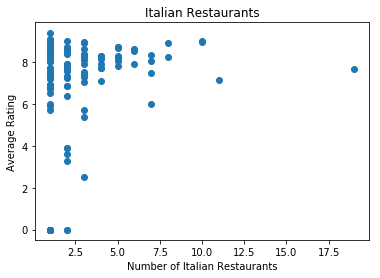

In [37]:
fig, ax = plt.subplots()
ax.scatter(Best_Loc['Venue'],Best_Loc['Ratings'])
ax.set(xlabel="Number of Italian Restaurants", ylabel="Average Rating",
       title="Italian Restaurants")
plt.show()

<H4>Our ideal location will be one of the neighbourhoods in the top-left region</H4>

<H2>Use K-means Clustering to group the neighborhoods</H2>

In [38]:
kclusters = 10
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Best_Loc)
Best_Loc['Cluster']=kmeans.labels_
Best_Loc=Best_Loc.sort_values('Cluster', ascending =False)
for i in range(10):
    print("\n\nCLUSTER:",i)
    print(Best_Loc[Best_Loc['Cluster']==i])



CLUSTER: 0
                           Venue  Ratings  Cluster
Neighborhood                                      
South Side                     1      8.1        0
Woodlawn                       1      8.3        0
St. George                     1      8.4        0
Tudor City                     1      8.3        0
Windsor Terrace                1      8.9        0
Washington Heights             1      8.7        0
Auburndale                     1      8.2        0
Morris Park                    1      8.7        0
Bellaire                       1      8.3        0
Rego Park                      1      8.4        0
Concourse Village              1      7.7        0
Fulton Ferry                   1      8.9        0
Georgetown                     1      8.6        0
Grasmere                       1      8.2        0
Hamilton Heights               1      9.0        0
Huguenot                       1      8.1        0
City Island                    1      8.2        0
Chinatown         

<H4>As we can see, Cluster 8 suits our requirements perfectly</H4>

<H2>Separate our desired neighborhoods</H2>

In [42]:
Best_Clus=(Best_Loc[Best_Loc['Cluster']==8])
Best_Clus

,Venue,Ratings,Cluster
Neighborhood,,,
Little Italy,2,9.000000,8
Carnegie Hill,2,8.400000,8
Manhattanville,2,8.700000,8
Greenpoint,2,8.550000,8
Astoria,3,7.900000,8
Midtown South,3,8.600000,8
Fort Greene,3,8.900000,8
Financial District,3,8.233333,8
Bushwick,2,8.450000,8


<H4>These are our desired neighbourhoods</H4>